In [218]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasRegressor
import os
import zipfile


#### Load files

In [219]:
script_dir = os.getcwd()

In [220]:
# Function to extract ZIP files directly into the same directory (without subfolders)
def extract_zip_files(script_dir):
    output_dir = os.path.join(script_dir, "data_with_indicators")

    for file in os.listdir(output_dir):
        if file.endswith(".zip"):
            zip_path = os.path.join(output_dir, file)
            extracted_file_name = file.replace(".zip", ".csv")
            extracted_file_path = os.path.join(output_dir, extracted_file_name)

            # Only extract if the CSV file does not exist
            if not os.path.exists(extracted_file_path):
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(output_dir)
                print(f"Extracted: {zip_path} → {extracted_file_path}")
            else:
                print(f"Skipping extraction (already exists): {extracted_file_path}")

In [221]:
extract_zip_files(script_dir)

Skipping extraction (already exists): /Users/linyan/Desktop/4211-project/crypto/data_with_indicators/crypto_prices_1m_validation_with_indicators.csv
Extracted: /Users/linyan/Desktop/4211-project/crypto/data_with_indicators/crypto_prices_1m_with_indicators.csv.zip → /Users/linyan/Desktop/4211-project/crypto/data_with_indicators/crypto_prices_1m_with_indicators.csv.csv


In [222]:
# Load both sentiment files
sent1 = pd.read_csv('../curr_news/aggregated_daily_sentiment.csv')
sent2 = pd.read_csv('../historic_news/aggregated_daily_sentiment.csv')

# Combine them in order: part 1 comes before part 2
sentiment = pd.concat([sent1, sent2], ignore_index=True)

# Rename and parse dates
sentiment.rename(columns={'Unnamed: 0': 'Datetime'}, inplace=True)
sentiment['Datetime'] = pd.to_datetime(sentiment['Datetime'])

# Reshape to long format: Date | Token | Sentiment
sentiment = sentiment.melt(id_vars='Datetime', var_name='Token', value_name='Sentiment')
sentiment['Datetime'] = sentiment['Datetime'].dt.normalize()
sentiment['Datetime'] = sentiment['Datetime'].dt.tz_localize(None)




#### Functions to set up model

In [372]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism() 


#Code for Hyperparameter Tuning
def load_and_preprocess_data(file_path, sentiment=sentiment):
    df = pd.read_csv(file_path)
    df['Datetime'] = df['Date']
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.sort_values(['Token', 'Datetime'], inplace=True)
    dates = list(df['Datetime'].copy()) # Maintain list of minute indices
    # Prepare crypto data date column
    df['Datetime'] = df['Datetime'].dt.normalize()
    df['Datetime'] = df['Datetime'].dt.tz_localize(None)
    
    # Insert sentiment by default
    if isinstance(sentiment, pd.DataFrame):
        # Merge daily sentiment into intraday stock data
        df = df.merge(sentiment, how='left', on=['Datetime', 'Token'])

        # then assign back the original datetime column
        df['Datetime'] = dates 
        df['Datetime'] = pd.to_datetime(df['Datetime'])
        # Fill any missing sentiment values with neutral (0)
        df['Sentiment'] = df['Sentiment'].fillna(0)
        
        df['Return'] = df.groupby('Token')['Close'].pct_change().shift(-1)  # Next period return as target
        non_features = ['Datetime', 'Token', 'Date', 'Return']
        feature_cols = [x for x in list(df.columns) if x not in non_features]
        df = df[feature_cols + non_features].dropna()
        df.dropna(inplace=True)
    
    # Do not insert sentiment if False
    elif sentiment == False:
        df['Return'] = df.groupby('Token')['Close'].pct_change().shift(-1)  # Next period return as target
        non_features = ['Datetime', 'Token', 'Date', 'Return']
        feature_cols = [x for x in list(df.columns) if x not in non_features]
        df = df[feature_cols + non_features].dropna()
        df.dropna(inplace=True)
    
  
    return df, feature_cols

# Prepare sequences for LSTM training
def prepare_sequences(df, feature_cols, sequence_length=20):
    
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    return_scaler = MinMaxScaler(feature_range=(0, 1))
    
    X_scaled = feature_scaler.fit_transform(df[feature_cols])
    y_scaled = return_scaler.fit_transform(df[['Return']])
    
    X_sequences, y_sequences, dates, close_prices = [], [], df['Datetime'].values[sequence_length:], df['Close'].values[sequence_length:]
    
    for i in range(len(X_scaled) - sequence_length):
        X_sequences.append(X_scaled[i:i+sequence_length])
        y_sequences.append(y_scaled[i+sequence_length])
    
    return np.array(X_sequences), np.array(y_sequences), dates, close_prices, return_scaler

# Split data into training and testing sets
def split_data(X, y, dates, close_prices, train_ratio=0.8):
    split_index = int(len(X) * train_ratio)
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:], dates[split_index:], close_prices[split_index:]



# Function to create model for GridSearchCV
def create_lstm_model(input_shape, layers=1, units_1=50, units_2=50, dropout_rate=0.2, learning_rate=0.001, optimizer='adam'):
    model = Sequential()  # Add this line to initialize the model
    # Explicitly define the input layer
    model.add(Input(shape=input_shape))  # Fix: Define input layer separately
    # First LSTM layer
    if layers == 1:
        
        model.add(LSTM(units=units_1))
    else:
        model.add(LSTM(units=units_1, return_sequences=True))
        model.add(Dropout(dropout_rate))
        
        # Additional LSTM layers
        for i in range(layers-2):
            model.add(LSTM(units=units_2, return_sequences=True))
            model.add(Dropout(dropout_rate))
        
        # Final LSTM layer
        model.add(LSTM(units=units_2))

    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))  # Output layer
    # Convert optimizer string to actual optimizer instance
    optimizer_instance = {
        'adam': tf.keras.optimizers.Adam(learning_rate=learning_rate),
        'rmsprop': tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        'sgd': tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    }[optimizer]
    model.compile(optimizer=optimizer_instance,
                    loss='mse',
                    metrics=['mae'])
    return model
# Function to train and evaluate the model
def train_and_evaluate_model_validation(df, feature_cols, validation, Token):
    df_Token = df[df['Token'] == Token]
    val_Token = validation[validation['Token'] == Token]
    X, y, dates, close_prices, return_scaler = prepare_sequences(df_Token, feature_cols)
    X_val, y_val, dates_val, close_prices_val, return_scaler_val = prepare_sequences(val_Token, feature_cols)
    
    # Hyperparameter tuning
    input_shape = (X.shape[1], X.shape[2])
    # Learning rate adjustment and early stopping
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
    if Token == 'BTC':
        model = create_lstm_model(input_shape, layers=1, units_1=100, units_2=50, dropout_rate=0.2, learning_rate=0.001, optimizer='adam')
        model.fit(X, y, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)
    
    elif Token == 'ETH':
        model = create_lstm_model(input_shape, layers=1, units_1=50, units_2=50, dropout_rate=0.2, learning_rate=0.001, optimizer='adam')
        model.fit(X, y, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=callbacks)
    elif Token == 'SOL':
        model = create_lstm_model(input_shape, layers=1, units_1=100, units_2=50, dropout_rate=0.4, learning_rate=0.001, optimizer='adam')
        model.fit(X, y, epochs=50, batch_size=16, validation_data=(X_val, y_val), callbacks=callbacks)
    elif Token == 'XRP':
        model = create_lstm_model(input_shape, layers=1, units_1=50, units_2=50, dropout_rate=0.1, learning_rate=0.001, optimizer='adam')
        model.fit(X, y, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)
    
    # Predict and rescale returns
    y_pred_scaled = model.predict(X_val)
    y_pred = return_scaler.inverse_transform(y_pred_scaled)
    y_val = return_scaler_val.inverse_transform(y_val.reshape(-1, 1))
    
    return model, y_val, y_pred, dates_val, close_prices_val



In [224]:
# Function to log trades and calculate cumulative return
def log_trades(dates, actual_returns, predicted_returns, close_prices, Token):
    positions = ['LONG' if pred > 0 else 'SHORT' for pred in predicted_returns.flatten()]
    
    # --- Apply trading strategy logic ---
    positions = np.where(predicted_returns.flatten() > 0, 'LONG', 'SHORT')
    strategy_returns = np.zeros_like(actual_returns.flatten())

    for i in range(len(actual_returns)):
        curr_position = positions[i]

        # Base return from position
        if curr_position == 'LONG':
            ret = actual_returns[i]
        elif curr_position == 'SHORT':
            ret = -actual_returns[i]
        else:
            ret = 0

        strategy_returns[i] = ret

    # Compute cumulative return
    cumulative_return = np.cumprod(1 + strategy_returns) - 1

    trades = pd.DataFrame({
        'Date': dates,
        'Close_Price': close_prices,
        'Predicted_Return': predicted_returns.flatten(),
        'Actual_Return': actual_returns,
        'Position': positions,
        'Strategy_Return': strategy_returns,
        'Cumulative_Return': cumulative_return,
        'Ticker': Token
    })
    
    return trades 


# Function to plot cumulative returns for each stock
def plot_cumulative_returns(all_trades_df):
    plt.figure(figsize=(12, 6))
    for Token in all_trades_df['Ticker'].unique():
        df_Token = all_trades_df[all_trades_df['Ticker'] == Token]
        plt.plot(df_Token['Date'], df_Token['Cumulative_Return'], label=Token)
    
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Cumulative Returns for Each Cryptocurrency')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Function to plot Buy & Hold strategy for the test period (last 20% of the dataset)
def plot_buy_and_hold_test_period(df):
    plt.figure(figsize=(12, 6))

    for Token in df['Token'].unique():
        df_Token = df[df['Token'] == Token].sort_values('Datetime')

        # Split data (80% train, 20% test)
        split_index = int(len(df_Token) * 0.8)
        df_test = df_Token.iloc[split_index:]  # Select last 20%

        if df_test.empty:
            continue  # Skip if no test data

        initial_price = df_test['Close'].iloc[0]
        buy_and_hold_returns = df_test['Close'] / initial_price  # Normalize returns

        plt.plot(df_test['Datetime'], buy_and_hold_returns, label=f'Buy & Hold {Token}')

    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Buy & Hold Strategy (Test Period)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()



#### 1. With sentiment

In [373]:
file_path1 = "./data_with_indicators/crypto_prices_1m_with_indicators.csv"
file_path2 = "./data_with_indicators/crypto_prices_1m_validation_with_indicators.csv"
df, feature_cols = load_and_preprocess_data(file_path1)
validation, feature_cols = load_and_preprocess_data(file_path2)

In [374]:

all_trades_val = []
unique_Tokens = ['BTC', 'ETH', 'SOL', 'XRP']


In [375]:
Token = 'BTC'
print(f"Processing {Token}...")
b_model_val, b_y_val, b_y_pred, b_dates_val, b_close_prices_val = train_and_evaluate_model_validation(df, feature_cols, validation, Token)


Processing BTC...
Epoch 1/50


2025-04-05 08:07:14.242455: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-04-05 08:07:14.243030: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

3680/3689 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - mae: 0.0411

2025-04-05 08:07:36.864225: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-04-05 08:07:36.864604: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

3689/3689 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.0048 - mae: 0.0411 - val_loss: 0.0077 - val_mae: 0.0830 - learning_rate: 0.0010
Epoch 2/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 6.0575e-04 - mae: 0.0170 - val_loss: 0.0060 - val_mae: 0.0722 - learning_rate: 0.0010
Epoch 3/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 5.0243e-04 - mae: 0.0144 - val_loss: 0.0060 - val_mae: 0.0719 - learning_rate: 0.0010
Epoch 4/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 4.8859e-04 - mae: 0.0140 - val_loss: 0.0060 - val_mae: 0.0721 - learning_rate: 0.0010
Epoch 5/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 4.8432e-04 - mae: 0.0138 - val_loss: 0.0060 - val_mae: 0.0724 - learning_rate: 0.0010
Epoch 6/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 4.8289e-04 - mae: 0.0138 - val_loss: 0.0061 - val_mae: 0.0725 - learning_rate: 5.0000e-04
Epoch 7/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 4.8290e-04 - mae: 0.0138 - val_loss: 0.0061 - val_mae:

2025-04-05 08:10:21.314672: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-05 08:10:21.315031: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1394/1394 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [376]:
btc_trades_val = log_trades(b_dates_val, b_y_val.flatten(), b_y_pred.flatten(), b_close_prices_val, 'BTC')
#all_trades_val.append(btc_trades_val)

In [190]:
Token = 'ETH'
print(f"Processing {Token}...")
e_model_val, e_y_val, e_y_pred, e_dates_val, e_close_prices_val = train_and_evaluate_model_validation(df, feature_cols, validation, Token)


Processing ETH...
Epoch 1/50
1839/1845 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128 - mae: 0.0682

2025-04-05 06:36:07.481077: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-04-05 06:36:07.481451: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1845/1845 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0128 - mae: 0.0681 - val_loss: 0.1216 - val_mae: 0.3482 - learning_rate: 0.0010
Epoch 2/50
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0011 - mae: 0.0257 - val_loss: 0.1233 - val_mae: 0.3507 - learning_rate: 0.0010
Epoch 3/50
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 2.5632e-04 - mae: 0.0120 - val_loss: 0.1198 - val_mae: 0.3456 - learning_rate: 0.0010
Epoch 4/50
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 8.7591e-05 - mae: 0.0060 - val_loss: 0.1178 - val_mae: 0.3427 - learning_rate: 0.0010
Epoch 5/50
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 7.9096e-05 - mae: 0.0055 - val_loss: 0.1164 - val_mae: 0.3406 - learning_rate: 0.0010
Epoch 6/50
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 7.7648e-05 - mae: 0.0054 - val_loss: 0.1167 - val_mae: 0.3411 - learning_rate: 0.0010
Epoch 7/50
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 7.6701e-05 - mae: 0.0053 - val_loss: 0.1178 - val_mae: 0.3427 - lear

2025-04-05 06:37:32.637233: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-05 06:37:32.637576: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1394/1394 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [191]:
# Log trades and update cumulative returns
eth_trades_val = log_trades(e_dates_val, e_y_val.flatten(), e_y_pred.flatten(), e_close_prices_val, 'ETH')
all_trades_val.append(eth_trades_val)

In [ ]:
Token = 'SOL'
print(f"Processing {Token}...")
s_model_val, s_y_val, s_y_pred, s_dates_val, s_close_prices_val = train_and_evaluate_model_validation(df, feature_cols, validation, Token)


Processing SOL...
Epoch 1/50
7378/7378 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 0.0059 - mae: 0.0431 - val_loss: 5.9432e-04 - val_mae: 0.0158 - learning_rate: 0.0010
Epoch 2/50
7378/7378 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 6.8829e-04 - mae: 0.0171 - val_loss: 5.9639e-04 - val_mae: 0.0159 - learning_rate: 0.0010
Epoch 3/50
7378/7378 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 6.7275e-04 - mae: 0.0167 - val_loss: 5.9575e-04 - val_mae: 0.0158 - learning_rate: 0.0010
Epoch 4/50
7378/7378 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 6.7226e-04 - mae: 0.0167 - val_loss: 5.9610e-04 - val_mae: 0.0158 - learning_rate: 0.0010
Epoch 5/50
7378/7378 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 6.7061e-04 - mae: 0.0167 - val_loss: 5.9230e-04 - val_mae: 0.0157 - learning_rate: 5.0000e-04
Epoch 6/50
7378/7378 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 6.7052e-04 - mae: 0.0167 - val_loss: 5.9254e-04 - val_mae: 0.0158 - learning_rate: 5.0000e-04
Epoch 7/50
7378/7378 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - los

2025-04-05 07:07:35.101360: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-05 07:07:35.101718: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1394/1394 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [193]:
# Log trades and update cumulative returns
sol_trades_val = log_trades(s_dates_val, s_y_val.flatten(), s_y_pred.flatten(), s_close_prices_val, 'SOL')
all_trades_val.append(sol_trades_val)

In [ ]:
Token = 'XRP'
print(f"Processing {Token}...")
xrp_model_val, xrp_y_val, xrp_y_pred, xrp_dates_val, xrp_close_prices_val = train_and_evaluate_model_validation(df, feature_cols, validation, Token)


Processing XRP...
Epoch 1/50
3683/3689 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0332

2025-04-05 07:07:51.004937: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-04-05 07:07:51.005322: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

3689/3689 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0031 - mae: 0.0331 - val_loss: 7.1221e-04 - val_mae: 0.0197 - learning_rate: 0.0010
Epoch 2/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 2.2052e-04 - mae: 0.0103 - val_loss: 7.4730e-04 - val_mae: 0.0206 - learning_rate: 0.0010
Epoch 3/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 1.6543e-04 - mae: 0.0082 - val_loss: 6.8898e-04 - val_mae: 0.0193 - learning_rate: 0.0010
Epoch 4/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 1.6099e-04 - mae: 0.0079 - val_loss: 6.6319e-04 - val_mae: 0.0187 - learning_rate: 0.0010
Epoch 5/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 1.5893e-04 - mae: 0.0078 - val_loss: 6.6647e-04 - val_mae: 0.0188 - learning_rate: 5.0000e-04
Epoch 6/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 1.5898e-04 - mae: 0.0078 - val_loss: 6.6718e-04 - val_mae: 0.0188 - learning_rate: 5.0000e-04
Epoch 7/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 1.5898e-04 - mae: 0.0078 -

2025-04-05 07:09:35.544197: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-05 07:09:35.544562: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1394/1394 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [195]:
# Log trades and update cumulative returns
xrp_trades_val = log_trades(xrp_dates_val, xrp_y_val.flatten(), xrp_y_pred.flatten(), xrp_close_prices_val, 'XRP')
all_trades_val.append(xrp_trades_val)

In [377]:
all_trades_val = [btc_trades_val, eth_trades_val, sol_trades_val, xrp_trades_val]

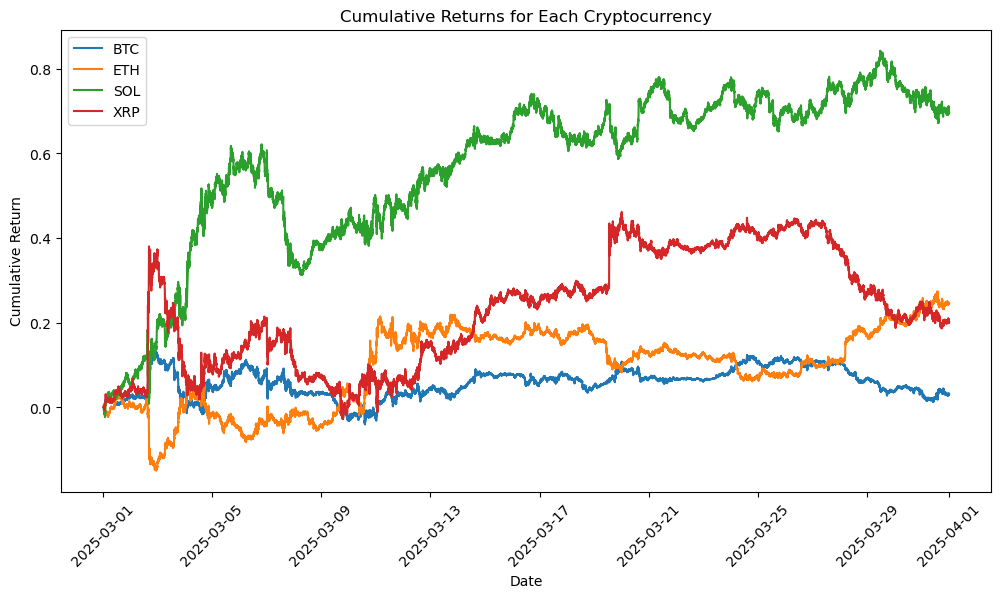

In [378]:

# Combine all trades into a single DataFrame
all_trades_val_df = pd.concat(all_trades_val, ignore_index=True)

# Plot cumulative returns for all stocks
plot_cumulative_returns(all_trades_val_df)

In [379]:
all_trades_val_df['Rolling_Risk'] = all_trades_val_df.groupby('Ticker')['Actual_Return'].transform(lambda x: x.rolling(window=10).std())
all_trades_val_df['Rolling_Average'] = all_trades_val_df.groupby('Ticker')['Actual_Return'].transform(lambda x: x.rolling(window=10).mean())


In [380]:
all_trades_val_df

,Date,Close_Price,Predicted_Return,Actual_Return,Position,Strategy_Return,Cumulative_Return,Ticker,Rolling_Risk,Rolling_Average
0,2025-03-01 00:47:00,84171.7000,0.000029,-0.001042,LONG,-0.001042,-0.001042,BTC,NaN,NaN
1,2025-03-01 00:48:00,84084.0100,0.000022,-0.000410,LONG,-0.000410,-0.001451,BTC,NaN,NaN
2,2025-03-01 00:49:00,84049.5300,0.000012,0.000084,LONG,0.000084,-0.001367,BTC,NaN,NaN
3,2025-03-01 00:50:00,84056.6000,-0.000010,-0.001631,SHORT,0.001631,0.000261,BTC,NaN,NaN
4,2025-03-01 00:51:00,83919.4900,0.000012,-0.000054,LONG,-0.000054,0.000207,BTC,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
178363,2025-03-31 23:54:00,2.0907,-0.000111,-0.000526,SHORT,0.000526,0.202394,XRP,0.000786,-0.000043
178364,2025-03-31 23:55:00,2.0896,-0.000095,0.000335,SHORT,-0.000335,0.201991,XRP,0.000784,0.000029
178365,2025-03-31 23:56:00,2.0903,-0.000104,-0.000144,SHORT,0.000144,0.202164,XRP,0.000743,0.000086
178366,2025-03-31 23:57:00,2.0900,-0.000081,0.000478,SHORT,-0.000478,0.201588,XRP,0.000751,0.000139


In [381]:
all_trades_val_df.to_csv("returns.csv", index=False)

In [382]:


# Function to calculate returns for both strategies during the test period
def calculate_strategy_returns_validation(df, all_trades_val_df):
    results = []
    df = df.rename(columns={"Token": "Ticker"})
    for Token in df['Ticker'].unique():
        df_Token = df[df['Ticker'] == Token].sort_values('Datetime')

        # Split data (80% train, 20% test)
        split_index = int(len(df_Token) * 0.8)
        df_test = df_Token.iloc[split_index:]  # Select last 20%

        if df_test.empty:
            continue  # Skip if no test data

        # Buy & Hold Strategy Return
        initial_price = df_test['Close'].iloc[0]
        final_price = df_test['Close'].iloc[-1]
        buy_and_hold_return = (final_price / initial_price) - 1

        # Trading Strategy Return (from the logged trades)
        df_trades = all_trades_val_df[all_trades_val_df['Ticker'] == Token]
        strategy_return = df_trades['Cumulative_Return'].iloc[-1] if not df_trades.empty else None

        results.append({
            "Ticker": Token,
            "Buy & Hold Return (%)": round(buy_and_hold_return * 100, 2),
            "Trading Strategy Return (%)": round(strategy_return * 100, 2) if strategy_return is not None else None
        })

    return pd.DataFrame(results)

# Check if trading results exist
if 'all_trades_val_df' in globals():
    strategy_returns_df = calculate_strategy_returns_validation(validation, all_trades_val_df)
    print(strategy_returns_df)
else:
    print("Trading strategy results are missing. Please re-run the trading model first.")




  Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
0    BTC                  -6.18                         3.25
1    ETH                 -11.69                        24.64
2    SOL                 -14.11                        69.43
3    XRP                 -14.85                        20.22


In [285]:
def calculate_trade_metrics(df):
    
    for ticker in ['BTC', 'ETH', 'SOL', 'XRP']:
        """
        Calculate trade statistics from a DataFrame containing trading data.

        Parameters:
            df (pandas.DataFrame): The DataFrame containing the trading data. It must include 
                                    the columns 'Date', 'Actual_Return', and 'Position'.

            Returns:
                dict: A dictionary containing the number of trades, average holding period (in minutes),
                    and average profit per trade.
        """
        df_ticker = df[df['Ticker'] == ticker].copy()  # Ensure a copy to avoid SettingWithCopyWarning

        # Ensure 'Date' column is in datetime format
        df_ticker.loc[:, 'Date'] = pd.to_datetime(df_ticker['Date'])


        # Identify trades by detecting changes in 'Position'
        df_ticker.loc[:, 'Trade_ID'] = (df_ticker['Position'] != df_ticker['Position'].shift(1)).cumsum()

        # Function to compute the trade return based on the trade's position.
        def calc_trade_return(group):
            pos = group['Position'].iloc[0].upper()
            if pos == "LONG":
                return np.prod(1 + group['Actual_Return']) - 1
            elif pos == "SHORT":
                return np.prod(1 - group['Actual_Return']) - 1
            else:
                return np.nan

        # Compute trade-level metrics: start and end times, and the trade's return.
        trade_metrics = df_ticker.groupby('Trade_ID').agg(
            start_date=('Date', 'first'),
            end_date=('Date', 'last'),
            position=('Position', 'first')
        ).reset_index()

        trade_metrics.loc[:, 'trade_return'] = df_ticker.groupby('Trade_ID').apply(calc_trade_return).values
        trade_metrics.loc[:, 'holding_period_minutes'] = (
            (trade_metrics['end_date'] - trade_metrics['start_date']).dt.total_seconds() / 60
        )

        # Calculate overall metrics
        num_trades = trade_metrics.shape[0]
        avg_holding_period = trade_metrics['holding_period_minutes'].mean()
        avg_profit_per_trade = trade_metrics['trade_return'].mean()

        metrics = {
            'num_trades': num_trades,
            'avg_holding_period_minutes': avg_holding_period,
            'avg_profit_per_trade': avg_profit_per_trade
        }
        
        print(f'{ticker}:'+ str(metrics))

calculate_trade_metrics(all_trades_val_df)

/var/folders/9d/bxxrjx5d1qg5y0x87t0hp84w0000gn/T/ipykernel_59053/138332891.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trade_metrics.loc[:, 'trade_return'] = df_ticker.groupby('Trade_ID').apply(calc_trade_return).values
/var/folders/9d/bxxrjx5d1qg5y0x87t0hp84w0000gn/T/ipykernel_59053/138332891.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trade_metrics.loc[:, 'trade_return'] = df_ticker.grou

BTC:{'num_trades': 1, 'avg_holding_period_minutes': 44591.0, 'avg_profit_per_trade': -0.019266451788438776}
ETH:{'num_trades': 293, 'avg_holding_period_minutes': 151.19112627986348, 'avg_profit_per_trade': 0.0008471072774032532}


/var/folders/9d/bxxrjx5d1qg5y0x87t0hp84w0000gn/T/ipykernel_59053/138332891.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trade_metrics.loc[:, 'trade_return'] = df_ticker.groupby('Trade_ID').apply(calc_trade_return).values


SOL:{'num_trades': 8091, 'avg_holding_period_minutes': 4.511308861698184, 'avg_profit_per_trade': 7.042306766305197e-05}
XRP:{'num_trades': 4305, 'avg_holding_period_minutes': 9.358188153310104, 'avg_profit_per_trade': 5.634889059492884e-05}


/var/folders/9d/bxxrjx5d1qg5y0x87t0hp84w0000gn/T/ipykernel_59053/138332891.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trade_metrics.loc[:, 'trade_return'] = df_ticker.groupby('Trade_ID').apply(calc_trade_return).values


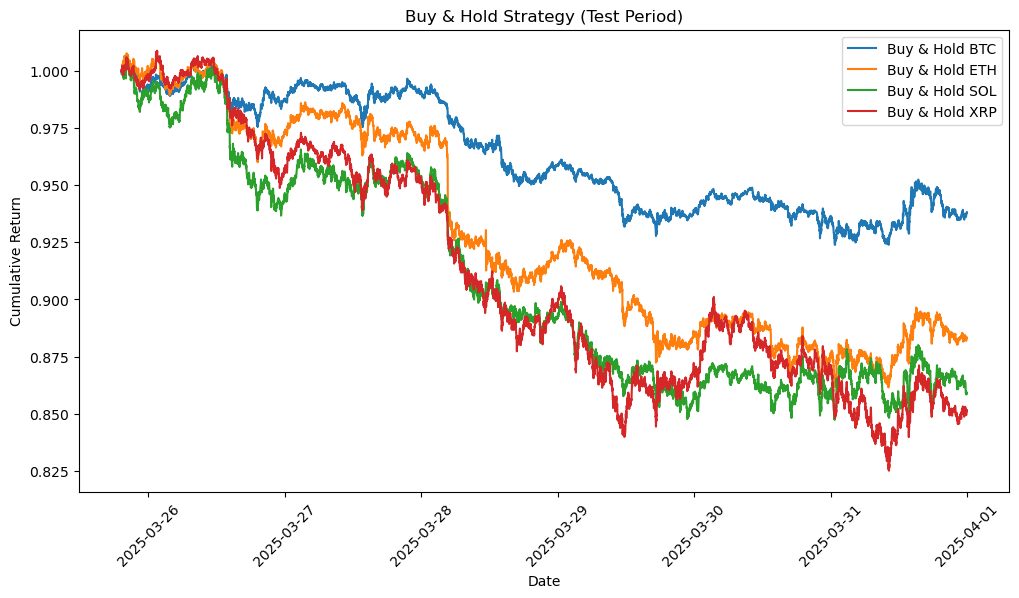

In [237]:
# Plot the Buy & Hold strategy for the test period
plot_buy_and_hold_test_period(validation)

In [238]:
# Sensitivity analysis function
def run_sensitivity_analysis(df):
    """
    Perform sensitivity analysis by adjusting the predicted returns and evaluating final cumulative return.
    """
    sensitivity_factors = [0.5, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5]
    results = []

    for factor in sensitivity_factors:
        df_temp = df.copy()
        df_temp['Adj_Predicted_Return'] = df_temp['Predicted_Return'] * factor

        positions = np.where(df_temp['Adj_Predicted_Return'] > 0, 'LONG', 'SHORT')
        strategy_returns = np.zeros_like(df_temp['Actual_Return'])

        for i in range(len(df_temp)):
            curr_position = positions[i]
            actual_ret = df_temp.loc[i, 'Actual_Return']

            if curr_position == 'LONG':
                ret = actual_ret
            elif curr_position == 'SHORT':
                ret = -actual_ret
            else:
                ret = 0

            strategy_returns[i] = ret

        cumulative_return = np.cumprod(1 + strategy_returns)[-1]
        results.append((factor, cumulative_return))

    df_sensitivity = pd.DataFrame(results, columns=["Adjustment_Factor", "Final_Cumulative_Return"])
    return df_sensitivity

In [383]:
btc_sensitivity = run_sensitivity_analysis(btc_trades_val)
btc_sensitivity

,Adjustment_Factor,Final_Cumulative_Return
0,0.5,1.032522
1,0.8,1.032522
2,0.9,1.032522
3,1.0,1.032522
4,1.1,1.032522
5,1.2,1.032522
6,1.5,1.032522


In [384]:
eth_sensitivity = run_sensitivity_analysis(eth_trades_val)
eth_sensitivity

,Adjustment_Factor,Final_Cumulative_Return
0,0.5,1.246378
1,0.8,1.246378
2,0.9,1.246378
3,1.0,1.246378
4,1.1,1.246378
5,1.2,1.246378
6,1.5,1.246378


In [385]:
sol_sensitivity = run_sensitivity_analysis(sol_trades_val)
sol_sensitivity

,Adjustment_Factor,Final_Cumulative_Return
0,0.5,1.694323
1,0.8,1.694323
2,0.9,1.694323
3,1.0,1.694323
4,1.1,1.694323
5,1.2,1.694323
6,1.5,1.694323


In [386]:
xrp_sensitivity = run_sensitivity_analysis(xrp_trades_val)
xrp_sensitivity

,Adjustment_Factor,Final_Cumulative_Return
0,0.5,1.202221
1,0.8,1.202221
2,0.9,1.202221
3,1.0,1.202221
4,1.1,1.202221
5,1.2,1.202221
6,1.5,1.202221


In [387]:
# Stress testing function
def run_stress_testing(df):
    """
    Perform stress tests by simulating various market shock scenarios.
    """
    scenarios = {
        'Crash': df['Actual_Return'] - 0.00005,  
        'Volatility_Spike': df['Actual_Return'] + np.random.normal(0, 0.00002, size=len(df)),
        'Prediction_Inverted': -df['Predicted_Return'],
        'Zero_Prediction': np.zeros_like(df['Predicted_Return']), 
        'Normal': df['Actual_Return']
    }

    results = []
    for scenario_name, shock in scenarios.items():
        df_temp = df.copy()

        if 'Prediction' in scenario_name:
            df_temp['Adj_Predicted_Return'] = shock
        else:
            df_temp['Adj_Predicted_Return'] = df_temp['Predicted_Return']
            df_temp['Actual_Return'] = shock

        positions = np.where(df_temp['Adj_Predicted_Return'] > 0, 'LONG', 'SHORT')
        strategy_returns = np.zeros_like(df_temp['Actual_Return'])

        for i in range(len(df_temp)):
            curr_position = positions[i]
            actual_ret = df_temp.loc[i, 'Actual_Return']

            if curr_position == 'LONG':
                ret = actual_ret
            elif curr_position == 'SHORT':
                ret = -actual_ret
            else:
                ret = 0

            strategy_returns[i] = ret

        cumulative_return = np.cumprod(1 + strategy_returns)[-1]
        results.append((scenario_name, cumulative_return))

    df_stress = pd.DataFrame(results, columns=["Scenario", "Final_Cumulative_Return"])
    return df_stress 

In [388]:
btc_stress_test = run_stress_testing(btc_trades_val)
btc_stress_test

,Scenario,Final_Cumulative_Return
0,Crash,0.118594
1,Volatility_Spike,1.031371
2,Prediction_Inverted,0.939089
3,Zero_Prediction,0.988679
4,Normal,1.032522


In [389]:
eth_stress_test = run_stress_testing(eth_trades_val)
eth_stress_test

,Scenario,Final_Cumulative_Return
0,Crash,11.173897
1,Volatility_Spike,1.244950
2,Prediction_Inverted,0.757274
3,Zero_Prediction,1.154881
4,Normal,1.246378


In [390]:
sol_stress_test = run_stress_testing(sol_trades_val)
sol_stress_test

,Scenario,Final_Cumulative_Return
0,Crash,2.027740
1,Volatility_Spike,1.686375
2,Prediction_Inverted,0.536357
3,Zero_Prediction,1.069075
4,Normal,1.694323


In [391]:
xrp_stress_test = run_stress_testing(xrp_trades_val)
xrp_stress_test

,Scenario,Final_Cumulative_Return
0,Crash,0.291304
1,Volatility_Spike,1.208416
2,Prediction_Inverted,0.743047
3,Zero_Prediction,0.913566
4,Normal,1.202221


#### 2. Without news sentiment

In [392]:
file_path1 = "./data_with_indicators/crypto_prices_1m_with_indicators.csv"
file_path2 = "./data_with_indicators/crypto_prices_1m_validation_with_indicators.csv"
df2, feature_cols2 = load_and_preprocess_data(file_path1, False)
validation2, feature_cols2 = load_and_preprocess_data(file_path2, False)

In [393]:
df2

,Open,High,Low,Close,Volume,Number of Trades,EMA9,EMA21,EMA_Buy,EMA_Sell,...,ADX_Buy,ADX_Sell,Aroon_Up,Aroon_Down,Aroon_Buy,Aroon_Sell,Datetime,Token,Date,Return
26,95042.8100,95084.2800,95042.8000,95077.3300,7.84473,1460,95169.479266,95253.233296,False,True,...,True,False,44.0,92.0,False,True,2024-12-31,BTC,2024-12-31 16:26:00,-0.001192
27,95077.3300,95077.3400,94930.4700,94964.0100,53.27052,4040,95128.385413,95226.940269,False,True,...,True,False,40.0,96.0,False,True,2024-12-31,BTC,2024-12-31 16:27:00,0.000319
28,94964.0100,95008.3000,94961.9000,94994.3000,13.26489,1723,95101.568330,95205.791154,False,True,...,True,False,36.0,92.0,False,True,2024-12-31,BTC,2024-12-31 16:28:00,-0.000390
29,94994.3000,95022.0000,94957.2800,94957.2800,7.78100,2337,95072.710664,95183.199231,False,True,...,True,False,32.0,88.0,False,True,2024-12-31,BTC,2024-12-31 16:29:00,0.000040
30,94957.2800,94978.9500,94928.0000,94961.0600,12.57003,2384,95050.380531,95163.004755,False,True,...,True,False,28.0,96.0,False,True,2024-12-31,BTC,2024-12-31 16:30:00,-0.002068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472318,2.4158,2.4158,2.4142,2.4143,26522.00000,285,2.415422,2.414865,True,False,...,False,True,40.0,0.0,True,False,2025-03-23,XRP,2025-03-23 15:55:00,-0.000331
472319,2.4143,2.4143,2.4132,2.4135,23576.00000,187,2.415038,2.414741,True,False,...,False,True,36.0,12.0,True,False,2025-03-23,XRP,2025-03-23 15:56:00,-0.000124
472320,2.4134,2.4134,2.4125,2.4132,19637.00000,217,2.414670,2.414601,True,False,...,False,True,32.0,8.0,True,False,2025-03-23,XRP,2025-03-23 15:57:00,0.000290
472321,2.4133,2.4139,2.4133,2.4139,33525.00000,213,2.414516,2.414537,False,True,...,False,True,28.0,4.0,True,False,2025-03-23,XRP,2025-03-23 15:58:00,-0.000249


In [394]:

all_trades_2 = []
unique_Tokens = ['BTC', 'ETH', 'SOL', 'XRP']


In [395]:
Token = 'BTC'
print(f"Processing {Token}...")
b_model_2, b_y_2, b_y_pred_2, b_dates_2, b_close_prices_2 = train_and_evaluate_model_validation(df2, feature_cols2, validation2, Token)


Processing BTC...
Epoch 1/50


2025-04-05 08:11:16.942751: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-04-05 08:11:16.943223: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

3686/3689 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - mae: 0.0318

2025-04-05 08:11:41.399304: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-04-05 08:11:41.399739: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

3689/3689 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 0.0023 - mae: 0.0317 - val_loss: 0.0063 - val_mae: 0.0739 - learning_rate: 0.0010
Epoch 2/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 5.4867e-04 - mae: 0.0157 - val_loss: 0.0061 - val_mae: 0.0730 - learning_rate: 0.0010
Epoch 3/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 4.9112e-04 - mae: 0.0141 - val_loss: 0.0060 - val_mae: 0.0719 - learning_rate: 0.0010
Epoch 4/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 4.8454e-04 - mae: 0.0139 - val_loss: 0.0060 - val_mae: 0.0723 - learning_rate: 0.0010
Epoch 5/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 4.8403e-04 - mae: 0.0138 - val_loss: 0.0061 - val_mae: 0.0724 - learning_rate: 0.0010
Epoch 6/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 4.8397e-04 - mae: 0.0138 - val_loss: 0.0061 - val_mae: 0.0724 - learning_rate: 0.0010
Epoch 7/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 4.8284e-04 - mae: 0.0138 - val_loss: 0.0061 - val_mae: 0.0

2025-04-05 08:14:27.165014: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-05 08:14:27.165398: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1394/1394 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [396]:
btc_trades_2 = log_trades(b_dates_2, b_y_2.flatten(), b_y_pred_2.flatten(), b_close_prices_2, 'BTC')
all_trades_2.append(btc_trades_2)

In [397]:
Token = 'ETH'
print(f"Processing {Token}...")
e_model_2, e_y_2, e_y_pred_2, e_dates_2, e_close_prices_2= train_and_evaluate_model_validation(df2, feature_cols2, validation2, Token)


Processing ETH...
Epoch 1/50
1836/1845 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 - mae: 0.0699

2025-04-05 08:14:39.567045: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-04-05 08:14:39.567439: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1845/1845 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0129 - mae: 0.0697 - val_loss: 0.1156 - val_mae: 0.3394 - learning_rate: 0.0010
Epoch 2/50
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0011 - mae: 0.0260 - val_loss: 0.1204 - val_mae: 0.3465 - learning_rate: 0.0010
Epoch 3/50
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 2.5602e-04 - mae: 0.0120 - val_loss: 0.1174 - val_mae: 0.3422 - learning_rate: 0.0010
Epoch 4/50
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 8.6479e-05 - mae: 0.0060 - val_loss: 0.1153 - val_mae: 0.3391 - learning_rate: 0.0010
Epoch 5/50
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 7.8824e-05 - mae: 0.0054 - val_loss: 0.1152 - val_mae: 0.3389 - learning_rate: 0.0010
Epoch 6/50
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 7.7617e-05 - mae: 0.0054 - val_loss: 0.1161 - val_mae: 0.3402 - learning_rate: 0.0010
Epoch 7/50
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 7.6707e-05 - mae: 0.0053 - val_loss: 0.1177 - val_mae: 0.3426 - lear

2025-04-05 08:16:00.936749: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-05 08:16:00.937136: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1394/1394 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [398]:
# Log trades and update cumulative returns
eth_trades_2 = log_trades(e_dates_2, e_y_2.flatten(), e_y_pred_2.flatten(), e_close_prices_2, 'ETH')
all_trades_2.append(eth_trades_2)

In [399]:
Token = 'SOL'
print(f"Processing {Token}...")
s_model_2, s_y_2, s_y_pred_2, s_dates_2, s_close_prices_2 = train_and_evaluate_model_validation(df2, feature_cols2, validation2, Token)


Processing SOL...
Epoch 1/50
7378/7378 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 0.0056 - mae: 0.0418 - val_loss: 5.9528e-04 - val_mae: 0.0158 - learning_rate: 0.0010
Epoch 2/50
7378/7378 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 6.8466e-04 - mae: 0.0171 - val_loss: 5.9627e-04 - val_mae: 0.0159 - learning_rate: 0.0010
Epoch 3/50
7378/7378 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 6.7260e-04 - mae: 0.0167 - val_loss: 5.9561e-04 - val_mae: 0.0158 - learning_rate: 0.0010
Epoch 4/50
7378/7378 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 6.7228e-04 - mae: 0.0167 - val_loss: 5.9565e-04 - val_mae: 0.0158 - learning_rate: 0.0010
Epoch 5/50
7378/7378 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 6.7058e-04 - mae: 0.0167 - val_loss: 5.9215e-04 - val_mae: 0.0157 - learning_rate: 5.0000e-04
Epoch 6/50
7378/7378 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 6.7056e-04 - mae: 0.0167 - val_loss: 5.9209e-04 - val_mae: 0.0157 - learning_rate: 5.0000e-04
Epoch 7/50
7378/7378 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - los

2025-04-05 08:35:53.449382: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-05 08:35:53.449722: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1394/1394 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [400]:
# Log trades and update cumulative returns
sol_trades_2 = log_trades(s_dates_2, s_y_2.flatten(), s_y_pred_2.flatten(), s_close_prices_2, 'SOL')
all_trades_2.append(sol_trades_2)

In [401]:
Token = 'XRP'
print(f"Processing {Token}...")
xrp_model_2, xrp_y_2, xrp_y_pred_2, xrp_dates_2, xrp_close_prices_2 = train_and_evaluate_model_validation(df2, feature_cols2, validation2, Token)


Processing XRP...
Epoch 1/50
3682/3689 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0343

2025-04-05 08:36:09.741553: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-04-05 08:36:09.741986: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

3689/3689 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0031 - mae: 0.0342 - val_loss: 8.4661e-04 - val_mae: 0.0227 - learning_rate: 0.0010
Epoch 2/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.5022e-04 - mae: 0.0112 - val_loss: 7.6372e-04 - val_mae: 0.0210 - learning_rate: 0.0010
Epoch 3/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 1.6785e-04 - mae: 0.0083 - val_loss: 6.8777e-04 - val_mae: 0.0193 - learning_rate: 0.0010
Epoch 4/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 1.6247e-04 - mae: 0.0080 - val_loss: 6.5458e-04 - val_mae: 0.0185 - learning_rate: 0.0010
Epoch 5/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 1.5995e-04 - mae: 0.0078 - val_loss: 6.6135e-04 - val_mae: 0.0186 - learning_rate: 0.0010
Epoch 6/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 1.5953e-04 - mae: 0.0078 - val_loss: 6.6158e-04 - val_mae: 0.0186 - learning_rate: 0.0010
Epoch 7/50
3689/3689 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 1.5891e-04 - mae: 0.0078 - val_los

2025-04-05 08:37:55.152138: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-05 08:37:55.152518: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1394/1394 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [402]:
# Log trades and update cumulative returns
xrp_trades_2 = log_trades(xrp_dates_2, xrp_y_2.flatten(), xrp_y_pred_2.flatten(), xrp_close_prices_2, 'XRP')
all_trades_2.append(xrp_trades_2)

In [403]:
all_trades_2 = [btc_trades_2, eth_trades_2, sol_trades_2, xrp_trades_2]

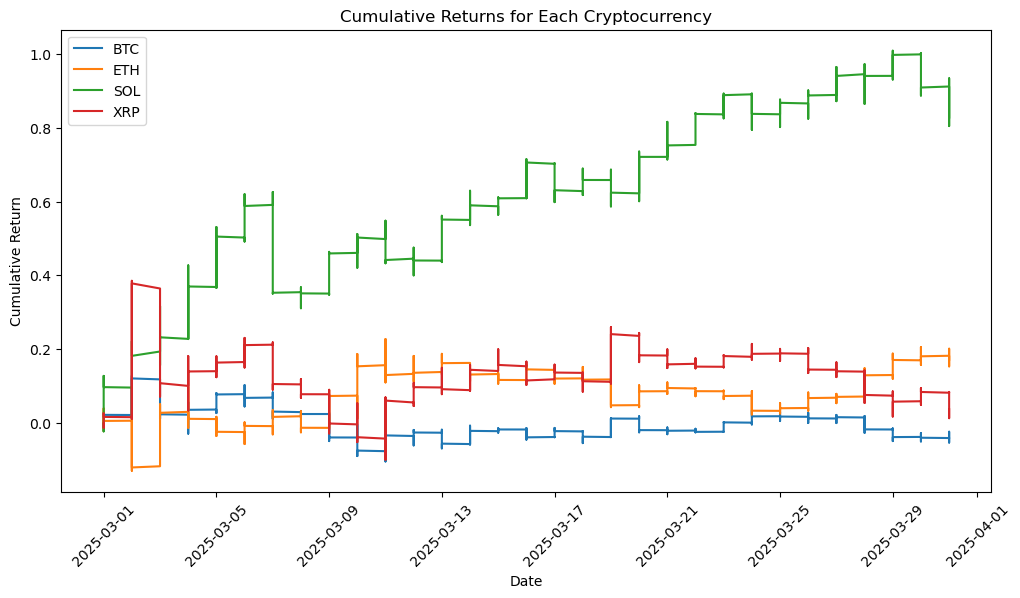

In [404]:

# Combine all trades into a single DataFrame
all_trades_2_df = pd.concat(all_trades_2, ignore_index=True)

# Plot cumulative returns for all stocks
plot_cumulative_returns(all_trades_2_df)

In [405]:
all_trades_2_df['Rolling_Risk'] = all_trades_2_df.groupby('Ticker')['Actual_Return'].transform(lambda x: x.rolling(window=10).std())
all_trades_2_df['Rolling_Average'] = all_trades_2_df.groupby('Ticker')['Actual_Return'].transform(lambda x: x.rolling(window=10).mean())


In [406]:
all_trades_2_df

,Date,Close_Price,Predicted_Return,Actual_Return,Position,Strategy_Return,Cumulative_Return,Ticker,Rolling_Risk,Rolling_Average
0,2025-03-01,84171.7000,0.000032,-0.001042,LONG,-0.001042,-0.001042,BTC,NaN,NaN
1,2025-03-01,84084.0100,0.000031,-0.000410,LONG,-0.000410,-0.001451,BTC,NaN,NaN
2,2025-03-01,84049.5300,0.000033,0.000084,LONG,0.000084,-0.001367,BTC,NaN,NaN
3,2025-03-01,84056.6000,0.000028,-0.001631,LONG,-0.001631,-0.002996,BTC,NaN,NaN
4,2025-03-01,83919.4900,0.000033,-0.000054,LONG,-0.000054,-0.003050,BTC,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
178363,2025-03-31,2.0907,0.000063,-0.000526,LONG,-0.000526,0.036920,XRP,0.000786,-0.000043
178364,2025-03-31,2.0896,0.000035,0.000335,LONG,0.000335,0.037268,XRP,0.000784,0.000029
178365,2025-03-31,2.0903,0.000007,-0.000144,LONG,-0.000144,0.037119,XRP,0.000743,0.000086
178366,2025-03-31,2.0900,0.000021,0.000478,LONG,0.000478,0.037615,XRP,0.000751,0.000139


In [407]:


# Function to calculate returns for both strategies during the test period
def calculate_strategy_returns_validation(df, all_trades_2_df):
    results = []
    df = df.rename(columns={"Token": "Ticker"})
    for Token in df['Ticker'].unique():
        df_Token = df[df['Ticker'] == Token].sort_values('Datetime')

        # Split data (80% train, 20% test)
        split_index = int(len(df_Token) * 0.8)
        df_test = df_Token.iloc[split_index:]  # Select last 20%

        if df_test.empty:
            continue  # Skip if no test data

        # Buy & Hold Strategy Return
        initial_price = df_test['Close'].iloc[0]
        final_price = df_test['Close'].iloc[-1]
        buy_and_hold_return = (final_price / initial_price) - 1

        # Trading Strategy Return (from the logged trades)
        df_trades = all_trades_2_df[all_trades_2_df['Ticker'] == Token]
        strategy_return = df_trades['Cumulative_Return'].iloc[-1] if not df_trades.empty else None

        results.append({
            "Ticker": Token,
            "Buy & Hold Return (%)": round(buy_and_hold_return * 100, 2),
            "Trading Strategy Return (%)": round(strategy_return * 100, 2) if strategy_return is not None else None
        })

    return pd.DataFrame(results)

# Check if trading results exist
if 'all_trades_2_df' in globals():
    strategy_returns_2_df = calculate_strategy_returns_validation(validation2, all_trades_2_df)
    print(strategy_returns_2_df)
else:
    print("Trading strategy results are missing. Please re-run the trading model first.")




  Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
0    BTC                  -5.13                        -3.90
1    ETH                 -11.81                        17.12
2    SOL                 -11.73                        82.80
3    XRP                 -14.25                         3.71


In [ ]:
def calculate_trade_metrics(df):
    
    for ticker in ['BTC', 'ETH', 'SOL', 'XRP']:
        """
        Calculate trade statistics from a DataFrame containing trading data.

        Parameters:
            df (pandas.DataFrame): The DataFrame containing the trading data. It must include 
                                    the columns 'Date', 'Actual_Return', and 'Position'.

            Returns:
                dict: A dictionary containing the number of trades, average holding period (in minutes),
                    and average profit per trade.
        """
        df_ticker = df[df['Ticker'] == ticker].copy()  # Ensure a copy to avoid SettingWithCopyWarning

        # Ensure 'Date' column is in datetime format
        df_ticker.loc[:, 'Date'] = pd.to_datetime(df_ticker['Date'])
        

        # Identify trades by detecting changes in 'Position'
        df_ticker.loc[:, 'Trade_ID'] = (df_ticker['Position'] != df_ticker['Position'].shift(1)).cumsum()

        # Function to compute the trade return based on the trade's position.
        def calc_trade_return(group):
            pos = group['Position'].iloc[0].upper()
            if pos == "LONG":
                return np.prod(1 + group['Actual_Return']) - 1
            elif pos == "SHORT":
                return np.prod(1 - group['Actual_Return']) - 1
            else:
                return np.nan

        # Compute trade-level metrics: start and end times, and the trade's return.
        trade_metrics = df_ticker.groupby('Trade_ID').agg(
            start_date=('Date', 'first'),
            end_date=('Date', 'last'),
            position=('Position', 'first')
        ).reset_index()

        trade_metrics.loc[:, 'trade_return'] = df_ticker.groupby('Trade_ID').apply(calc_trade_return).values
        trade_metrics.loc[:, 'holding_period_minutes'] = (
            (trade_metrics['end_date'] - trade_metrics['start_date']).dt.total_seconds() / 60
        )

        # Calculate overall metrics
        num_trades = trade_metrics.shape[0]
        avg_holding_period = trade_metrics['holding_period_minutes'].mean()
        avg_profit_per_trade = trade_metrics['trade_return'].mean()

        metrics = {
            'num_trades': num_trades,
            'avg_holding_period_minutes': avg_holding_period,
            'avg_profit_per_trade': avg_profit_per_trade
        }
        
        print(f'{ticker}:'+ str(metrics))

calculate_trade_metrics(all_trades_2_df)

BTC:{'num_trades': 7, 'avg_holding_period_minutes': 6171.428571428572, 'avg_profit_per_trade': -0.0050455830170962656}
ETH:{'num_trades': 3, 'avg_holding_period_minutes': 14400.0, 'avg_profit_per_trade': 0.05971367740884551}
SOL:{'num_trades': 6799, 'avg_holding_period_minutes': 5.930283865274305, 'avg_profit_per_trade': 9.515420989602502e-05}


/var/folders/9d/bxxrjx5d1qg5y0x87t0hp84w0000gn/T/ipykernel_59053/3116025039.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trade_metrics.loc[:, 'trade_return'] = df_ticker.groupby('Trade_ID').apply(calc_trade_return).values
/var/folders/9d/bxxrjx5d1qg5y0x87t0hp84w0000gn/T/ipykernel_59053/3116025039.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trade_metrics.loc[:, 'trade_return'] = df_ticker.gr

XRP:{'num_trades': 457, 'avg_holding_period_minutes': 94.52954048140043, 'avg_profit_per_trade': 0.00013451758630755314}


/var/folders/9d/bxxrjx5d1qg5y0x87t0hp84w0000gn/T/ipykernel_59053/3116025039.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trade_metrics.loc[:, 'trade_return'] = df_ticker.groupby('Trade_ID').apply(calc_trade_return).values


In [409]:
all_trades_2_df

,Date,Close_Price,Predicted_Return,Actual_Return,Position,Strategy_Return,Cumulative_Return,Ticker,Rolling_Risk,Rolling_Average
0,2025-03-01,84171.7000,0.000032,-0.001042,LONG,-0.001042,-0.001042,BTC,NaN,NaN
1,2025-03-01,84084.0100,0.000031,-0.000410,LONG,-0.000410,-0.001451,BTC,NaN,NaN
2,2025-03-01,84049.5300,0.000033,0.000084,LONG,0.000084,-0.001367,BTC,NaN,NaN
3,2025-03-01,84056.6000,0.000028,-0.001631,LONG,-0.001631,-0.002996,BTC,NaN,NaN
4,2025-03-01,83919.4900,0.000033,-0.000054,LONG,-0.000054,-0.003050,BTC,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
178363,2025-03-31,2.0907,0.000063,-0.000526,LONG,-0.000526,0.036920,XRP,0.000786,-0.000043
178364,2025-03-31,2.0896,0.000035,0.000335,LONG,0.000335,0.037268,XRP,0.000784,0.000029
178365,2025-03-31,2.0903,0.000007,-0.000144,LONG,-0.000144,0.037119,XRP,0.000743,0.000086
178366,2025-03-31,2.0900,0.000021,0.000478,LONG,0.000478,0.037615,XRP,0.000751,0.000139
